In [3]:
CONFIG = {
    "layers_list": [5],
    "init_types": [
        "he_normal", "he_uniform",
        "xavier_normal", "xavier_uniform",
        "normal", "zero",
        "orthogonal", "trunc_normal"
    ],
    "activations": [ "sigmoid"],
    "init_params": {
        "he_normal":   {"factor": 2.0, "mode": "fan_in", "nonlinearity": "relu"},
        "he_uniform":  {"factor": 2.0, "mode": "fan_in", "nonlinearity": "relu"},
        "orthogonal":  {"gain": 1.0},
        "trunc_normal": {"mean": 0.0, "std": 0.01, "a": -2.0, "b": 2.0}
    },
    "hidden_size": 128,
    "input_size": 784,
    "output_size": 10,
    "num_epochs": 500,
    "lr": 0.01,
    "batch_size": 128,
    "save_dir": "results"
}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import math
import os
import time
from typing import Dict

# ==================== 配置参数 ====================


# 创建保存目录
def make_plot_dir():
    os.makedirs(CONFIG["save_dir"], exist_ok=True)

# 激活函数获取器
def get_activation(name: str):
    if name == "relu":    return F.relu
    if name == "tanh":    return torch.tanh
    if name == "sigmoid": return torch.sigmoid
    if name == "gelu":    return F.gelu
    raise ValueError(f"Unsupported activation: {name}")

# 模型定义
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, activation):
        super().__init__()
        self.activation_fn = get_activation(activation)
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_hidden_layers)
        ])
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden:
            x = self.activation_fn(layer(x))
        return self.output(x)

# 权重初始化
def initialize_weights(model: nn.Module, init_type: str, params: Dict = None):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            p = params or {}
            if init_type == 'he_normal':
                fan = nn.init._calculate_correct_fan(m.weight, p.get('mode','fan_in'))
                std = math.sqrt(p.get('factor',2.0) / fan)
                nn.init.normal_(m.weight, 0.0, std)
            elif init_type == 'he_uniform':
                fan = nn.init._calculate_correct_fan(m.weight, p.get('mode','fan_in'))
                bound = math.sqrt(3.0 * p.get('factor',2.0) / fan)
                nn.init.uniform_(m.weight, -bound, bound)
            elif init_type == 'xavier_normal': nn.init.xavier_normal_(m.weight)
            elif init_type == 'xavier_uniform': nn.init.xavier_uniform_(m.weight)
            elif init_type == 'normal': nn.init.normal_(m.weight, p.get('mean',0.0), p.get('std',0.01))
            elif init_type == 'zero': nn.init.constant_(m.weight, 0.0)
            elif init_type == 'orthogonal': nn.init.orthogonal_(m.weight, p.get('gain',1.0))
            elif init_type == 'trunc_normal':
                nn.init.trunc_normal_(m.weight, p.get('mean',0.0), p.get('std',0.01), p.get('a',-2.0), p.get('b',2.0))
            else:
                raise ValueError(f"Unknown init type: {init_type}")
            nn.init.constant_(m.bias, 0.0)

# 数据加载
def get_dataloaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))
    ])
    train_dataset = datasets.MNIST('./data', True, download=True, transform=transform)
    test_dataset  = datasets.MNIST('./data', False, download=True, transform=transform)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练
def train(model, optimizer, criterion, loader, device):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (output.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# 验证
def evaluate(model, criterion, loader, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(0)
            correct += (output.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# 实验执行 (含 activation hooks + gradient hooks + 保存 stats)
def run_experiment(init_type: str, num_layers: int, activation: str, config: Dict):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = get_dataloaders(config['batch_size'])
    model = DeepMLP(config['input_size'], config['hidden_size'], config['output_size'], num_layers, activation).to(device)

    # hooks 列表
    layer_acts = [[] for _ in model.hidden]
    layer_grads = [[] for _ in model.hidden]

    # hook 工厂函数
    def make_forward_hook(idx):
        def forward_hook(module, inp, out):
            layer_acts[idx].append(out.detach().cpu().numpy())
        return forward_hook
    def make_backward_hook(idx):
        def backward_hook(module, grad_in, grad_out):
            layer_grads[idx].append(grad_out[0].detach().cpu().numpy())
        return backward_hook

    # 注册 hooks
    for idx, layer in enumerate(model.hidden):
        layer.register_forward_hook(make_forward_hook(idx))
        layer.register_full_backward_hook(make_backward_hook(idx))

    # 初始化
    init_params = config.get('init_params', {}).get(init_type, {})
    initialize_weights(model, init_type, init_params)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    # 构造 history，包含基础和 per-layer stats
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'epoch_time': []}
    for i in range(num_layers):
        history[f'act_mean_{i}'] = []
        history[f'act_std_{i}'] = []
        history[f'grad_norm_{i}'] = []

    prefix = f"{init_type}_{activation}_{num_layers}L"

    # 逐 epoch
    for ep in range(1, config['num_epochs'] + 1):
        # 清空缓存
        for lst in layer_acts: lst.clear()
        for lst in layer_grads: lst.clear()

        start = time.time()
        tl, ta = train(model, optimizer, criterion, train_loader, device)
        vl, va = evaluate(model, criterion, test_loader, device)
        duration = time.time() - start

        # 记录基础指标
        history['train_loss'].append(tl)
        history['test_loss'].append(vl)
        history['train_acc'].append(ta)
        history['test_acc'].append(va)
        history['epoch_time'].append(duration)

        # 记录 per-layer stats
        for i, layer in enumerate(model.hidden):
            # 激活拼接数组
            acts_arr = np.concatenate([a.reshape(-1) for a in layer_acts[i]]) if layer_acts[i] else np.array([])
            history[f'act_mean_{i}'].append(acts_arr.mean() if acts_arr.size else np.nan)
            history[f'act_std_{i}'].append(acts_arr.std() if acts_arr.size else np.nan)
            # 梯度范数
            grads_arr = np.concatenate([g.reshape(-1) for g in layer_grads[i]]) if layer_grads[i] else np.array([])
            history[f'grad_norm_{i}'].append(np.linalg.norm(grads_arr))

        print(f"[{init_type}|{activation}|{num_layers}L] "
              f"Ep{ep}/{config['num_epochs']} "
              f"TL={tl:.4f} TA={ta:.4f} VL={vl:.4f} VA={va:.4f} T={duration:.2f}s")

    # 保存 CSV
    df = pd.DataFrame(history)
    os.makedirs(config['save_dir'], exist_ok=True)
    df.to_csv(os.path.join(config['save_dir'], f"{prefix}.csv"), index=False)
    return history

# 主流程

def main():
    make_plot_dir()
    total_exps = len(CONFIG['init_types']) * len(CONFIG['activations']) * len(CONFIG['layers_list'])
    completed = 0
    overall_start = time.time()

    for init in CONFIG['init_types']:
        for act in CONFIG['activations']:
            for layer_count in CONFIG['layers_list']:
                run_experiment(init, layer_count, act, CONFIG)
                completed += 1
                elapsed = time.time() - overall_start
                avg_per = elapsed / completed
                remaining = avg_per * (total_exps - completed)
                print(f"[{completed}/{total_exps}] Elapsed={time.strftime('%H:%M:%S', time.gmtime(elapsed))} "
                      f"ETA={time.strftime('%H:%M:%S', time.gmtime(remaining))}")

if __name__ == '__main__':
    main()

[he_normal|sigmoid|5L] Ep1/500 TL=2.3076 TA=0.1100 VL=2.3020 VA=0.1028 T=2.45s
[he_normal|sigmoid|5L] Ep2/500 TL=2.3018 TA=0.1103 VL=2.3011 VA=0.1135 T=2.30s
[he_normal|sigmoid|5L] Ep3/500 TL=2.3017 TA=0.1104 VL=2.3012 VA=0.1135 T=2.18s
[he_normal|sigmoid|5L] Ep4/500 TL=2.3015 TA=0.1121 VL=2.3012 VA=0.1028 T=2.16s
[he_normal|sigmoid|5L] Ep5/500 TL=2.3013 TA=0.1126 VL=2.3008 VA=0.1135 T=2.19s
[he_normal|sigmoid|5L] Ep6/500 TL=2.3013 TA=0.1135 VL=2.3029 VA=0.1028 T=2.20s
[he_normal|sigmoid|5L] Ep7/500 TL=2.3012 TA=0.1120 VL=2.3005 VA=0.1135 T=2.32s
[he_normal|sigmoid|5L] Ep8/500 TL=2.3011 TA=0.1109 VL=2.3009 VA=0.1135 T=2.16s
[he_normal|sigmoid|5L] Ep9/500 TL=2.3009 TA=0.1122 VL=2.3008 VA=0.1135 T=2.11s
[he_normal|sigmoid|5L] Ep10/500 TL=2.3009 TA=0.1125 VL=2.3004 VA=0.1135 T=2.18s
[he_normal|sigmoid|5L] Ep11/500 TL=2.3007 TA=0.1127 VL=2.3002 VA=0.1135 T=2.17s
[he_normal|sigmoid|5L] Ep12/500 TL=2.3005 TA=0.1135 VL=2.2997 VA=0.1135 T=2.17s
[he_normal|sigmoid|5L] Ep13/500 TL=2.3004 TA=0.11

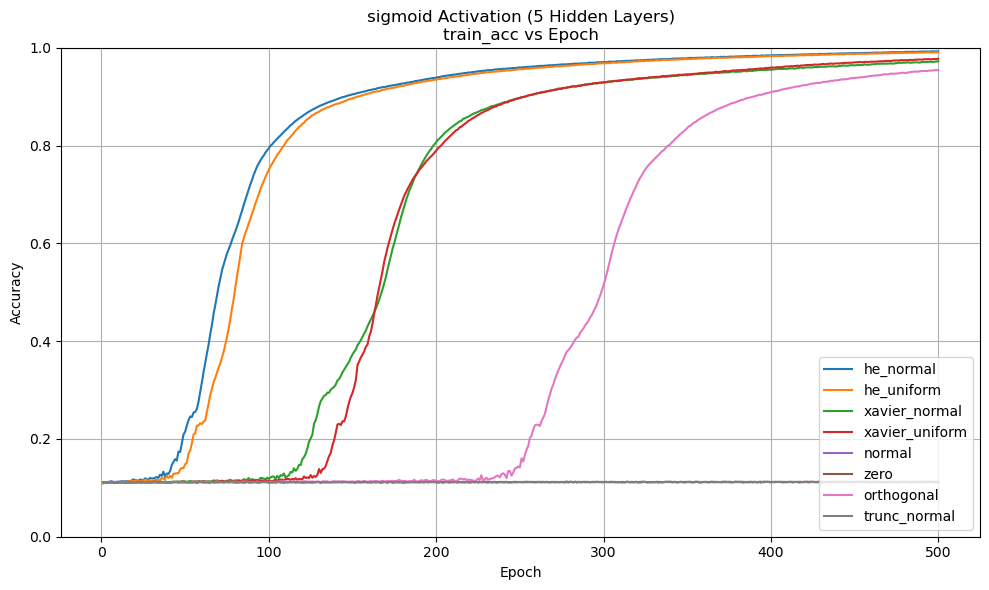

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ========== 配置 ==========
DATA_DIR = "results"
activation = "sigmoid"
init_types = [
    "he_normal", "he_uniform",
    "xavier_normal", "xavier_uniform",
    "normal", "zero",
    "orthogonal", "trunc_normal"
]
num_layers = 5  # 你可以改为 5, 10, 50 等
target_column = "train_acc"  # 可替换为 "test_acc"

# ========== 主函数 ==========
def plot_accuracy_vs_epoch_all_inits():
    plt.figure(figsize=(10, 6))
    for init in init_types:
        filename = f"{init}_{activation}_{num_layers}L.csv"
        path = os.path.join(DATA_DIR, filename)
        if not os.path.exists(path):
            print(f"⚠️ 缺失文件: {path}")
            continue

        df = pd.read_csv(path)
        if target_column not in df.columns:
            print(f"⚠️ 缺失列: {target_column} in {filename}")
            continue

        epochs = list(range(1, len(df[target_column]) + 1))
        plt.plot(epochs, df[target_column], label=init)

    plt.title(f"{activation} Activation ({num_layers} Hidden Layers)\n{target_column} vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# ========== 执行 ==========
plot_accuracy_vs_epoch_all_inits()